# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import shutil
import tensorflow as tf
import warnings

from copy import deepcopy
from google.colab import drive
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from tabulate import tabulate

In [3]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pylab
import random
import tensorflow as tf
import wave

from pathlib import Path
from PIL import Image
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

# Supress Warnings

In [4]:
# Supress warnings
warnings.resetwarnings()
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

# Global Variables

In [5]:
dataset_dir = "/content/drive/MyDrive/Group Project/Dataset/"
single_1_dir = dataset_dir + "Model Ready/Single Cell/Batched/"
single_2_dir = dataset_dir + "Preprocessed/Single Cell/intermediate_GSE132465_GEO_processed_CRC_10X_natural_log_TPM_matrix/"
multi_dir = dataset_dir + "Model Ready/Multi Cell/Batched Long New/"

data_dir = "data/"
source_dir = data_dir + "source/"
target_dir = data_dir + "target/"

# Load Data

In [6]:
for d in [target_dir]:
    if not os.path.exists(d):
        os.makedirs(d)

## Multi Cell

In [7]:
shutil.copytree(multi_dir, source_dir)

'data/source/'

In [8]:
data = None
for i in range(10000):
    if data is None:
        data = pd.read_csv(source_dir + "batch_%d.csv"%(i))
    else:
        data = pd.concat([data, pd.read_csv(source_dir + "batch_%d.csv"%(i))])

l = data.shape[0]
split_1 = int(l*0.8)
split_2 = int((l - split_1) / 2)

source_data = {"train": None, "val": None, "test": None}
source_data["train"] = data.sample(split_1, axis=0, replace=False)
source_data["val"] = data.sample(split_2, replace=False)
source_data["test"] = data.sample((l-split_1-split_2), replace=False)

for k in ["train", "val", "test"]:
    cols = list(source_data[k].columns)
    x = source_data[k][cols[:-1]]
    y = source_data[k][cols[-1]]
    source_data[k] = {"x": x, "y": y}

## Single Cell

## Make Batch Files

In [9]:
target_dir_len = len(os.listdir(single_1_dir))

In [10]:
# target_dir_len = 5
c = 0
df = None
for f in os.listdir(single_2_dir):
    if c == target_dir_len:
        break
    tmp = pd.read_csv(single_2_dir + f)
    tmp = tmp.assign(label=1)
    if df is None:
        df = deepcopy(tmp)
    else:
        df = pd.concat([df, tmp], axis=0, ignore_index=True)

    while len(df) > 64:
        tmp = df.sample(64, replace=False, axis=0)
        batch = pd.read_csv(single_1_dir + "batch_%d.csv"%(c))
        batch = batch.assign(label=0)
        batch = pd.concat([batch, tmp], axis=0, ignore_index=True)
        batch = batch.sample(frac=1, random_state=42, axis=0)
        batch.to_csv(target_dir + "batch_%d.csv"%(c), index=False)
        c += 1
        print(c)

        if c == target_dir_len:
            break

Streaming output truncated to the last 5000 lines.
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507

## Load Into Memory

In [11]:
data = None
for i in range(1000):
    if data is None:
        data = pd.read_csv(target_dir + "batch_%d.csv"%(i))
    else:
        data = pd.concat([data, pd.read_csv(target_dir + "batch_%d.csv"%(i))])

l = len(data)
split_1 = int(l*0.8)
split_2 = int((l - split_1) / 2)

target_data = {"train": None, "val": None, "test": None}
target_data["train"] = data.sample(split_1, axis=0, replace=False)
target_data["val"] = data.sample(split_2, replace=False)
target_data["test"] = data.sample((l-split_1-split_2), replace=False)

for k in ["train", "val", "test"]:
    cols = list(target_data[k].columns)
    x = target_data[k][cols[:-1]]
    y = target_data[k][cols[-1]]
    target_data[k] = {"x": x, "y": y}

In [12]:
len(target_data["train"]["x"])

102400

In [13]:
len(target_data["val"]["x"])

12800

In [14]:
len(target_data["test"]["x"])

12800

In [15]:
del data

# Model Handler

In [23]:
from tensorflow.python.tools import module_util
class Trainer():

    def __init__(self):
        self.name = ""

    def build_model(self, model, input_shape, n_labels, model_type):
        
        # Build dense model
        if model_type == "dense":
            model.add(tf.keras.layers.Dense(200, activation="relu"))
            model.add(tf.keras.layers.Dense(100, activation="relu"))
            model.add(tf.keras.layers.Dense(50, activation="relu"))

        elif module_util == "lstm": 
            model.add(tf.keras.layers.LSTM(200))
            model.add(tf.keras.layers.LSTM(100))
            model.add(tf.keras.layers.LSTM(50))

        model.add(tf.keras.layers.Dense(n_labels, activation="softmax"))
        return model
    
    def build_source_model(self, input_shape, n_labels, model_type):
        model = tf.keras.Sequential([tf.keras.layers.Input(shape=input_shape)])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                           metrics=["accuracy"]
                           )
        self.model = self.build_model(model, input_shape, n_labels, model_type)

    def build_transfer_model(self, input_shape, n_labels, model_type, train_layers):
        model = tf.keras.Sequential([tf.keras.layers.Input(shape=input_shape)])
        tmp = self.build_model(model, input_shape, n_labels, model_type)

        for new_layer, layer in zip(tmp.layers[1:-train_layers], self.model.layers[1:-train_layers]):
            new_layer.set_weights(layer.get_weights())
            new_layer.trainable = False

        for new_layer, layer in zip(tmp.layers[-train_layers:-1], self.model.layers[-train_layers:-1]):
            new_layer.set_weights(layer.get_weights())
            
        tmp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                    metrics=["accuracy"]
                    )
        
        self.model = deepcopy(tmp)

    def train_model_dataset(self, train_x, train_y, val_x, val_y, epochs):
        self.history = self.model.fit(train_x, train_y, epochs=epochs, validation_data=(val_x, val_y))

    def test_model_dataset(self, test_x, test_y, n_labels, verbose=True):
        preds = self.model.predict(test_x)
        preds_select = np.apply_along_axis(np.argmax, 1, preds)
        true = [y for y in test_y.values]

        loss, acc = self.model.evaluate(test_x, test_y, verbose=2)
        scores = precision_recall_fscore_support(true, preds_select, average='macro')
        pre = scores[0]
        re = scores[1]
        f1 = scores[2]

        cm_labels = [x for x in range(n_labels)]
        cm = confusion_matrix(true, preds_select, labels=cm_labels)

        if verbose:
            print("\nModel Results:")
            print("Loss: %f\nAccuracy: %f\nPrecision: %f\nRecall: %f\nF1: %f"%(loss, acc, pre, re, f1))
            print("\nConfusion Matrix:")
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_labels)
            disp.plot()

        return loss, acc, pre, re, f1, preds, cm

# Training

In [24]:
name = "dense"

source_input_shape = (200)
target_input_shape = (200)

source_classes = 31
target_classes = 2

epochs = 20
train_layers = 2

In [25]:
# # Source
model = Trainer()
model.build_source_model(source_input_shape, source_classes, name)
model.train_model_dataset(source_data["train"]["x"], source_data["train"]["y"], source_data["val"]["x"], source_data["val"]["y"], epochs)

Epoch 1/20
31000/31000 [==============================] - 78s 3ms/step - loss: 3.4350 - accuracy: 0.0323 - val_loss: 3.4341 - val_accuracy: 0.0333
Epoch 2/20
31000/31000 [==============================] - 76s 2ms/step - loss: 3.4343 - accuracy: 0.0320 - val_loss: 3.4344 - val_accuracy: 0.0327
Epoch 3/20
31000/31000 [==============================] - 81s 3ms/step - loss: 3.4342 - accuracy: 0.0321 - val_loss: 3.4343 - val_accuracy: 0.0324
Epoch 4/20
31000/31000 [==============================] - 80s 3ms/step - loss: 3.4343 - accuracy: 0.0321 - val_loss: 3.4341 - val_accuracy: 0.0327
Epoch 5/20
31000/31000 [==============================] - 77s 2ms/step - loss: 3.4343 - accuracy: 0.0324 - val_loss: 3.4343 - val_accuracy: 0.0324
Epoch 6/20
31000/31000 [==============================] - 76s 2ms/step - loss: 3.4343 - accuracy: 0.0321 - val_loss: 3.4343 - val_accuracy: 0.0322
Epoch 7/20
31000/31000 [==============================] - 75s 2ms/step - loss: 3.4343 - accuracy: 0.0324 - val_loss: 3

3875/3875 [==============================] - 5s 1ms/step
3875/3875 - 6s - loss: 3.4342 - accuracy: 0.0324 - 6s/epoch - 1ms/step

Model Results:
Loss: 3.434204
Accuracy: 0.032395
Precision: 0.001045
Recall: 0.032258
F1: 0.002024

Confusion Matrix:


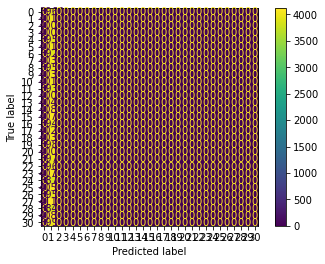

In [26]:
_ = model.test_model_dataset(source_data["test"]["x"], source_data["test"]["y"], source_classes)

In [27]:
# Target
model.build_transfer_model(target_input_shape, target_classes, name, train_layers)
model.train_model_dataset(target_data["train"]["x"], target_data["train"]["y"], target_data["val"]["x"], target_data["val"]["y"], epochs)

Epoch 1/20
3200/3200 [==============================] - 8s 2ms/step - loss: 0.1826 - accuracy: 0.5222 - val_loss: 0.1175 - val_accuracy: 0.5168
Epoch 2/20
3200/3200 [==============================] - 8s 2ms/step - loss: 0.1002 - accuracy: 0.5119 - val_loss: 0.0723 - val_accuracy: 0.5147
Epoch 3/20
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0499 - accuracy: 0.5037 - val_loss: 0.0225 - val_accuracy: 0.5038
Epoch 4/20
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0694 - accuracy: 0.5045 - val_loss: 0.0195 - val_accuracy: 0.5016
Epoch 5/20
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0703 - accuracy: 0.5050 - val_loss: 0.0282 - val_accuracy: 0.4937
Epoch 6/20
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0341 - accuracy: 0.5012 - val_loss: 0.0171 - val_accuracy: 0.4990
Epoch 7/20
3200/3200 [==============================] - 9s 3ms/step - loss: 0.0274 - accuracy: 0.5011 - val_loss: 0.0236 - val_accuracy:

400/400 [==============================] - 1s 1ms/step
400/400 - 1s - loss: 0.0041 - accuracy: 0.5038 - 599ms/epoch - 1ms/step

Model Results:
Loss: 0.004137
Accuracy: 0.503750
Precision: 0.998819
Recall: 0.998840
F1: 0.998828

Confusion Matrix:


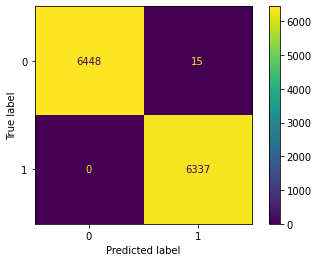

In [28]:
_ = model.test_model_dataset(target_data["test"]["x"], target_data["test"]["y"], target_classes)

In [29]:
# Baseline
model = Trainer()
model.build_source_model(target_input_shape, target_classes, name)
model.train_model_dataset(target_data["train"]["x"], target_data["train"]["y"], target_data["val"]["x"], target_data["val"]["y"], epochs*2)

Epoch 1/40
3200/3200 [==============================] - 8s 2ms/step - loss: 0.1605 - accuracy: 0.9439 - val_loss: 0.0511 - val_accuracy: 0.9866
Epoch 2/40
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0624 - accuracy: 0.9816 - val_loss: 0.0233 - val_accuracy: 0.9956
Epoch 3/40
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0472 - accuracy: 0.9867 - val_loss: 0.0053 - val_accuracy: 0.9988
Epoch 4/40
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0336 - accuracy: 0.9904 - val_loss: 0.0359 - val_accuracy: 0.9891
Epoch 5/40
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0270 - accuracy: 0.9920 - val_loss: 0.0309 - val_accuracy: 0.9906
Epoch 6/40
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0293 - accuracy: 0.9921 - val_loss: 0.0052 - val_accuracy: 0.9992
Epoch 7/40
3200/3200 [==============================] - 8s 2ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.0051 - val_accuracy:

400/400 [==============================] - 1s 1ms/step
400/400 - 1s - loss: 9.5448e-04 - accuracy: 0.9999 - 610ms/epoch - 2ms/step

Model Results:
Loss: 0.000954
Accuracy: 0.999922
Precision: 0.999921
Recall: 0.999923
F1: 0.999922

Confusion Matrix:


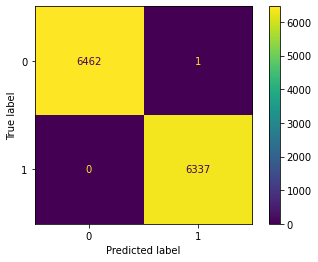

In [30]:
_ = model.test_model_dataset(target_data["test"]["x"], target_data["test"]["y"], target_classes)

# Bottom